# Interstate 94 Traffic Volume

In this tutorial, we demonstrate a **time series application of getML**. The analysis uses a dataset containing the hourly traffic volume on I-94 westbound from Minneapolis-St Paul. It is provided by the [MN Department of Transportation](https://www.dot.state.mn.us), with some data preparation done by [John Hogue](https://github.com/dreyco676/Anomaly_Detection_A_to_Z/). The dataset features some **particularly interesting characteristics** common for time series, which **classical models may struggle** to appropriately deal with. Such characteristics are:

- High frequency (hourly)
- Dependence on irregular events (holidays)
- Strong and overlapping cycles (daily, weekly)
- Anomalies
- Multiple seasonalities

Throughout the analysis, we **benchmark our results against [Facebook's Prophet](https://facebook.github.io/prophet/)**.

You are **encouraged to follow along with the notebook**. Required python dependencies are `pandas`, `numpy`, `scipy` and `matplotlib`. Download getML 0.11 from [our Website](https://getml.com/product) and refer to the [installation guide](https://docs.getml.com/latest/home/installation/installation.html).

## Data Preparation

As most readers should be familiar with pandas, we use that for our data preparation. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
# Read traffic volume time series to pandas
data = ('https://raw.githubusercontent.com/'
        'dreyco676/Anomaly_Detection_A_to_Z/'
        '72e77f0aea05a5eb7d18dfcb4e294d8c3cbc5bbf/ts_traffic.csv')

traffic = pd.read_csv(data)
traffic['ds'] = pd.to_datetime(traffic['ds'])

# Use only data after t_min
t_min = np.datetime64('2016')
traffic = traffic[traffic['ds'] >= t_min]

We split data into a training and a test set. Due to the natural ordering of the time series, we cannot randomly split the series. We therefore introduce a fixed split at the time where 80% of the data is passed.

In [3]:
total_time = traffic['ds'].max() - traffic['ds'].min()
print('Total time:', total_time)

t_split = traffic['ds'].min() + total_time*0.8
t_split = t_split.round('1h')
idx_train = traffic['ds'] < t_split

Total time: 1003 days 23:00:00


A plot of the full data set divided into training and testing data.

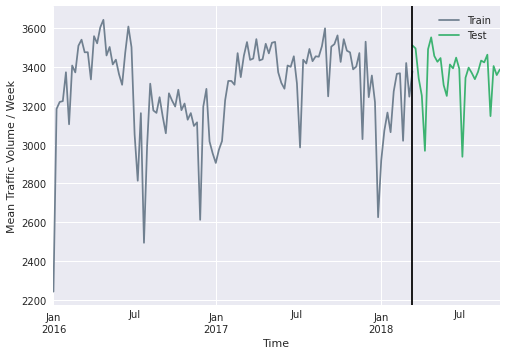

In [4]:
col_data = 'slategray'
col_getml = 'darkviolet'
col_getml_alt = 'coral'
col_prophet = 'cornflowerblue'

traffic[idx_train].set_index('ds').resample('1w').mean()['Traffic_Volume'].plot(label='Train', color=col_data)
traffic[~idx_train].set_index('ds').resample('1w').mean()['Traffic_Volume'].plot(label='Test', color='mediumseagreen')
plt.legend()
plt.ylabel('Mean Traffic Volume / Week')
plt.xlabel('Time')
plt.axvline(t_split, color='black')
plt.show()

## getML Setup

Importing getML and setting the project.

In [5]:
import getml

getml.engine.set_project('interstate94')

Creating new project 'interstate94'


### Data Preparation
To allow the algorithm to capture seasonal information, we include time components (such as the day of the week) as categorical variables.

In [6]:
traffic['hour'] = traffic['ds'].dt.hour
traffic['weekday'] = traffic['ds'].dt.dayofweek
traffic['day'] = traffic['ds'].dt.day
traffic['month'] = traffic['ds'].dt.month
traffic['year'] = traffic['ds'].dt.year
traffic.head()

,ds,Traffic_Volume,hour,weekday,day,month,year
122712,2016-01-01 00:00:00,1513,0,4,1,1,2016
122713,2016-01-01 01:00:00,1550,1,4,1,1,2016
122714,2016-01-01 02:00:00,993,2,4,1,1,2016
122715,2016-01-01 03:00:00,719,3,4,1,1,2016
122716,2016-01-01 04:00:00,533,4,4,1,1,2016


In [7]:
# We introduce a constant join key to allow for a full self join
traffic['join_key'] = 1

Define the [roles](https://docs.getml.com/latest/user_guide/annotating_data/annotating_data.html#roles). The roles tell getML **what you want to do** with these columns.

In [8]:
roles = dict(
    time_stamp=['ds'],
    join_key=['join_key'],
    target=['Traffic_Volume'],
    categorical=['hour', 'weekday', 'day', 'month', 'year'])

Load the pandas dataframes into native getML dataframes. The dataframes live on the engine and allow for a highly efficient processing of the algorithm. We set the dataframes' name on the engine through the `name` argument.

In [9]:
df_full = getml.data.DataFrame.from_pandas(
    traffic, name='full', roles=roles)

df_train = getml.data.DataFrame.from_pandas(
    traffic[idx_train], name='train', roles=roles)

df_test = getml.data.DataFrame.from_pandas(
    traffic[~idx_train], name='test', roles=roles)

Set the [units](https://docs.getml.com/latest/user_guide/annotating_data/annotating_data.html#units). Units allow the engine to directly compare columns to each other. For instance, "hour" can be compared with "hour", but not "weekday".

In [10]:
for df in [df_full, df_train, df_test]:
    df.set_unit('hour', 'hour')
    df.set_unit('weekday', 'weekday')
    df.set_unit('day', 'day')
    df.set_unit('month', 'month')
    df.set_unit('year', 'year')

### Defining the data model
The data model is the abstract model the feature learner follows when learning features. We manually replicate the appropriate time series structure through placeholders by setting time series related join conditions (`horizon`, `memory` and `allow_lagged_targets`).

In this example, our data model consists of two tables. The population table, holding the target and the contemporarily available time-based components we extracted above, and the peripheral table, which in our case is the same table as as the population table. In database terminology relating tabular information to itself is called a *self join.* This self join in getML's data model is further restricted through the join conditions mentioned above. This prevents us from introducing data leaks (`horizon`) and keeps the the computations feasible (`memory`). You can consult the last three lines of the SQL transpilation of a feature below to see the join conditions in action.

In [11]:
population = getml.data.Placeholder('population')

peripheral = getml.data.Placeholder('peripheral')

# 1. The horizon is 1 hour (we predict the next hour). 
# 2. The memory is 7 days, so we allow the algorithm to 
#    use information from up to 7 days. 
# 3. We allow lagged targets, thus the algorithm is able to 
#    identify autoregressive processes.

population.join(
    peripheral,
    join_key='join_key',
    time_stamp='ds',
    horizon=getml.data.time.hours(1),
    memory=getml.data.time.days(7),
    allow_lagged_targets=True
)

population

placeholder,other placeholder,allow lagged targets,horizon,join keys used,memory,other join keys used,other time stamps used,time stamps used,upper time stamps used
population,peripheral,True,3600.0,join_key,604800.0,join_key,ds,ds,


Defining feature learner and predictor.

In [12]:
multirel = getml.feature_learning.MultirelModel(
    num_features=10,
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    seed=4367
)

relboost = getml.feature_learning.RelboostModel(
    num_features=10,
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    seed=4367
)

predictor = getml.predictors.XGBoostRegressor(reg_lambda=500)

pipe = getml.pipeline.Pipeline(
    tags=['memory: 7d', 'horizon: 1h', 'multirel', 'relboost'],
    population=population,
    peripheral=[peripheral],
    feature_learners=[multirel, relboost],
    predictors=[predictor]
)

pipe

Pipeline(feature_learners=['MultirelModel', 'RelboostModel'], 
         feature_selectors=[], include_categorical=False, 
         peripheral=['peripheral'], population='population', 
         predictors=['XGBoostRegressor'], 
         tags=['memory: 7d', 'horizon: 1h', 'multirel', 'relboost'], 
         share_selected_features=0.5)

It is always a good idea to call `.check` before `.fit`, so we still have time for some last-minute changes.

In [13]:
pipe.check(df_train, [df_full])

Checking data model...
OK.


We now fit our pipeline. This should take about 6–8 minutes, depending on your machine.

In [14]:
pipe.fit(df_train, [df_full])

Checking data model...
OK.

MultirelModel: Training features...
[========================================] 100%

RelboostModel: Training features...
[========================================] 100%

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:5m:35.296838



Pipeline(feature_learners=['MultirelModel', 'RelboostModel'], 
         feature_selectors=[], include_categorical=False, 
         peripheral=['peripheral'], population='population', 
         predictors=['XGBoostRegressor'], 
         tags=['memory: 7d', 'horizon: 1h', 'multirel', 'relboost'], 
         share_selected_features=0.5)

url: /user/getml-getml-demo-py50cete/proxy/1709/getpipeline/1jJr1H/0/

### Model evaluation

Score the model.

In [15]:
in_sample = pipe.score(df_train, [df_full])
print('In sample:', in_sample)

out_of_sample = pipe.score(df_test, [df_full])
print('Out of sample:', out_of_sample)


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

In sample: {'mae': [219.24213417973056], 'rmse': [341.87796271075854], 'rsquared': [0.9697954651459705]}

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

Out of sample: {'mae': [205.05170746482753], 'rmse': [331.7133492664497], 'rsquared': [0.9721658295247855]}


Feature importances.

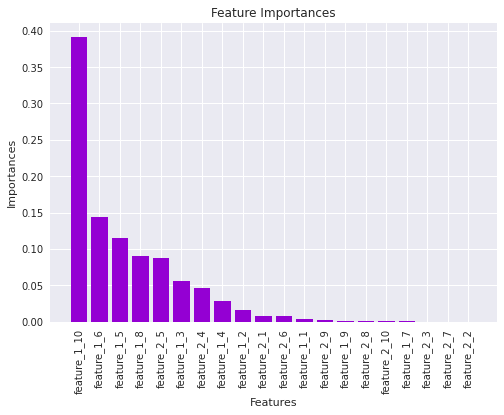

In [16]:
names, importances = pipe.features.importances()

plt.bar(names, importances, color=col_getml)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

most_important = names[0]

Correlations of the calculated features with the target.

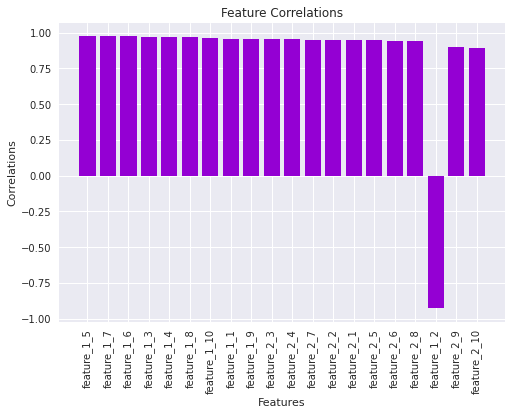

In [17]:
names, correlations = pipe.features.correlations()
plt.bar(names, correlations, color=col_getml)
plt.title('Feature Correlations')
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

In [18]:
# Feature overview
pipe.features.to_pandas().head()

,names,correlations,importances,target,sql
0,feature_1_1,0.955068,0.003444,Traffic_Volume,"CREATE TABLE ""FEATURE_1_1"" AS\nSELECT MIN( t2...."
1,feature_1_2,-0.925776,0.016144,Traffic_Volume,"CREATE TABLE ""FEATURE_1_2"" AS\nSELECT SUM( ( j..."
2,feature_1_3,0.973009,0.055244,Traffic_Volume,"CREATE TABLE ""FEATURE_1_3"" AS\nSELECT SUM( t2...."
3,feature_1_4,0.972632,0.028054,Traffic_Volume,"CREATE TABLE ""FEATURE_1_4"" AS\nSELECT AVG( t2...."
4,feature_1_5,0.974716,0.114444,Traffic_Volume,"CREATE TABLE ""FEATURE_1_5"" AS\nSELECT SUM( t2...."


In [19]:
# SQL transpilation of most important feature
pipe.features.to_sql()[most_important]

```sql
CREATE TABLE "FEATURE_1_10" AS
SELECT AVG( t2."Traffic_Volume" ) AS "feature_1_10",
       t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "peripheral" t2
ON t1."join_key" = t2."join_key"
WHERE (
   ( ( datetime( t1."ds" ) > datetime( t2."ds", '+1.891459 hours' ) ) AND ( datetime( t1."ds" ) > datetime( t2."ds", '+6.987649 days' ) ) AND ( t2."hour" NOT IN ( '7', '11', '12', '13', '14', '17', '21' ) ) )
OR ( ( datetime( t1."ds" ) > datetime( t2."ds", '+1.891459 hours' ) ) AND ( datetime( t1."ds" ) <= datetime( t2."ds", '+6.987649 days' ) ) AND ( t1."hour" NOT IN ( '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '20', '21', '22', '23' ) ) AND ( t1."day" NOT IN ( '2', '6', '10', '11', '13', '23', '28', '30' ) ) )
OR ( ( datetime( t1."ds" ) <= datetime( t2."ds", '+1.891459 hours' ) ) AND ( t2."hour" NOT IN ( '0', '1', '2', '3', '22', '23' ) ) AND ( t2."Traffic_Volume" > 593.027027 ) )
OR ( ( datetime( t1."ds" ) <= datetime( t2."ds", '+1.891459 hours' ) ) AND ( t2."hour" IN ( '0', '1', '2', '3', '22', '23' ) ) AND ( t2."Traffic_Volume" > 4248.714286 ) )
) AND datetime( t2."ds", '+1.000000 hours' ) <= datetime( t1."ds" )
AND ( datetime( t2."ds", '+7.041667 days' ) > datetime( t1."ds" ) OR datetime( t2."ds", '+7.041667 days' ) IS NULL )
GROUP BY t1.rowid;
```

This is a Multirel feature. Here, Multirel aggregated past values of the target (from up to one week ago) conditonal on time-related components to resemble the daily, weekly and montly cycles in the series. We expect this approach to work reasonably well because the series exhibits strong and stable time-related patterns. 

Now we plot the most important feature against the observed values of the target for the last 7 days of the training set.

In [20]:
features = pipe.transform(df_train, [df_full], df_name=f'{pipe.name}_features')


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%



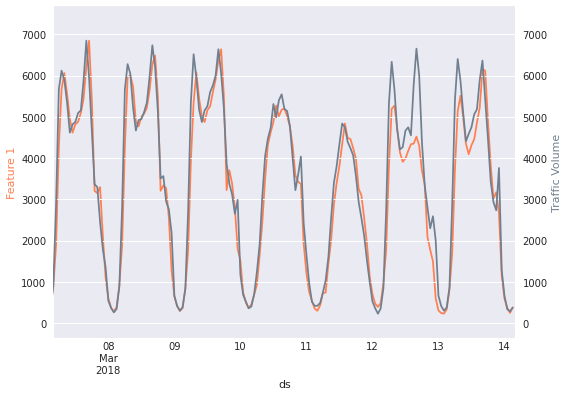

In [21]:
# plot most important feature and actual data over the course of one week
fig, ax1 = plt.subplots()

features.to_pandas().set_index('ds')[most_important].plot(ax=ax1, color=col_getml_alt)
ax1.set_ylabel('Feature 1', color=col_getml_alt)

ax2 = ax1.twinx()  
ax2.set_ylabel('Traffic Volume', color=col_data)
traffic[idx_train].set_index('ds')['Traffic_Volume'].plot(ax=ax2, color=col_data)

fig.tight_layout()
plt.xlim(t_split - pd.Timedelta('7d'), t_split)
plt.show()

You can see that this feature closely follows the original series. Multirel was able to identify certain patterns in the series, including:
- Day and night separation 
- The daily commuting peeks (on weekdays)
- The decline on weekends

## Forecasts with getML
In a second model, we only include deterministic features in our analysis. This model resembles component-based models like used by Prophet and is capable of delivering infinite horizon forecasts. The algorithm here only picks time-based components like daily or weekly cycles or seasonalities observed throughout the year. However, we would be able to deliver forecasts over any desireable horizon just by passing a dataframe consisting of solely time-based features to `predict()`, i.e. the timestamp itself, the hour, the weekday, the day, the month and the year. All this information is deterministic and thus avaiable for any given point in the future. Note that this constitutes a cornercase application of getML. 

We can basically reuse everything from above, but have to set the `allow_lagged_targets` join condition to `False` to prevent the algorithm from incorporating the lagged traffic volume. 

In [22]:
population.allow_lagged_targets = [False]

pipe_forecast = getml.pipeline.Pipeline(
    tags=['memory: 7d', 'multirel', 'relboost', 'forecast', 'deterministic regressors only'],
    population=population,
    peripheral=[peripheral],
    feature_learners=[multirel, relboost],
    predictors=[predictor]
)

pipe_forecast

Pipeline(feature_learners=['MultirelModel', 'RelboostModel'], 
         feature_selectors=[], include_categorical=False, 
         peripheral=['peripheral'], population='population', 
         predictors=['XGBoostRegressor'], 
         tags=['memory: 7d', 'multirel', 'relboost', 'forecast', 'deterministic regressors only'], 
         share_selected_features=0.5)

In [23]:
pipe_forecast.check(df_train, [df_full])

Checking data model...
OK.


In [24]:
pipe_forecast.fit(df_train, [df_full])

Checking data model...
OK.

MultirelModel: Training features...
[========================================] 100%

RelboostModel: Training features...
[========================================] 100%

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:4m:53.140216



Pipeline(feature_learners=['MultirelModel', 'RelboostModel'], 
         feature_selectors=[], include_categorical=False, 
         peripheral=['peripheral'], population='population', 
         predictors=['XGBoostRegressor'], 
         tags=['memory: 7d', 'multirel', 'relboost', 'forecast', 'deterministic regressors only'], 
         share_selected_features=0.5)

url: /user/getml-getml-demo-py50cete/proxy/1709/getpipeline/aIyfyV/0/

Score the forecast model.

In [25]:
in_sample_forecast = pipe_forecast.score(df_train, [df_full])
print('In sample:', in_sample_forecast)

out_of_sample_forecast = pipe_forecast.score(df_test, [df_full])
print('Out of sample:', out_of_sample_forecast)


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

In sample: {'mae': [318.7626221263574], 'rmse': [501.4353987127531], 'rsquared': [0.9349547182468716]}

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

Out of sample: {'mae': [282.523013432293], 'rmse': [445.7692626906232], 'rsquared': [0.950987322413932]}


We only lose about 2 percantage points of predictive accuracy when dropping all past information about the traffic volume. This is already a clear indication for the presence of strong and stabe time-related patterns in the series.

Now, we evaluate the learned features.

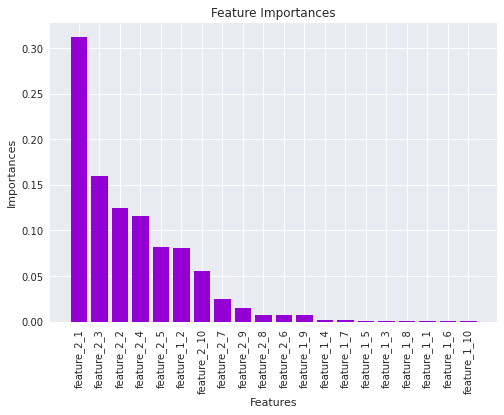

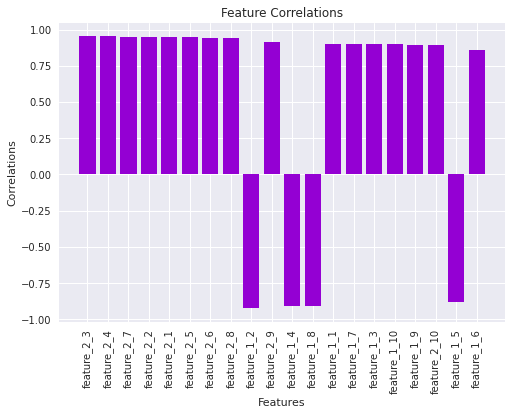

In [26]:
# Feature importances
names, importances = pipe_forecast.features.importances()
plt.bar(names, importances, color=col_getml)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

most_important = names[0]

# Feature correlations
names, correlations = pipe_forecast.features.correlations()
plt.bar(names, correlations, color=col_getml)
plt.title('Feature Correlations')
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

In [27]:
# Feature overview
pipe_forecast.features.to_pandas().head()

,names,correlations,importances,target,sql
0,feature_1_1,0.901434,0.000478,Traffic_Volume,"CREATE TABLE ""FEATURE_1_1"" AS\nSELECT MAX( ( j..."
1,feature_1_2,-0.922919,0.081314,Traffic_Volume,"CREATE TABLE ""FEATURE_1_2"" AS\nSELECT AVG( ( j..."
2,feature_1_3,0.898171,0.000829,Traffic_Volume,"CREATE TABLE ""FEATURE_1_3"" AS\nSELECT SUM( ( j..."
3,feature_1_4,-0.908656,0.001887,Traffic_Volume,"CREATE TABLE ""FEATURE_1_4"" AS\nSELECT AVG( ( j..."
4,feature_1_5,-0.881972,0.001090,Traffic_Volume,"CREATE TABLE ""FEATURE_1_5"" AS\nSELECT MIN( ( j..."


Here is the SQL transpilation of most important feature:

In [28]:
pipe_forecast.features.to_sql()[most_important]

```sql
CREATE TABLE "FEATURE_2_1" AS
SELECT AVG( 
    CASE
        WHEN ( t1."hour" IN ( '0', '1', '2', '3', '4', '5', '20', '21', '22', '23' ) ) AND ( t1."hour" IN ( '0', '1', '2', '3', '4', '23' ) ) AND ( t1."hour" IN ( '23' ) ) THEN 45.837508
        WHEN ( t1."hour" IN ( '0', '1', '2', '3', '4', '5', '20', '21', '22', '23' ) ) AND ( t1."hour" IN ( '0', '1', '2', '3', '4', '23' ) ) AND ( t1."hour" NOT IN ( '23' ) ) THEN -860.840797
        WHEN ( t1."hour" IN ( '0', '1', '2', '3', '4', '5', '20', '21', '22', '23' ) ) AND ( t1."hour" NOT IN ( '0', '1', '2', '3', '4', '23' ) ) AND ( t1."weekday" IN ( '0', '6' ) ) THEN 560.975227
        WHEN ( t1."hour" IN ( '0', '1', '2', '3', '4', '5', '20', '21', '22', '23' ) ) AND ( t1."hour" NOT IN ( '0', '1', '2', '3', '4', '23' ) ) AND ( t1."weekday" NOT IN ( '0', '6' ) ) THEN 1231.925929
        WHEN ( t1."hour" NOT IN ( '0', '1', '2', '3', '4', '5', '20', '21', '22', '23' ) ) AND ( t1."weekday" IN ( '5', '6' ) ) AND ( t1."hour" IN ( '6', '7', '8' ) ) THEN 318.905123
        WHEN ( t1."hour" NOT IN ( '0', '1', '2', '3', '4', '5', '20', '21', '22', '23' ) ) AND ( t1."weekday" IN ( '5', '6' ) ) AND ( t1."hour" NOT IN ( '6', '7', '8' ) ) THEN 2615.810479
        WHEN ( t1."hour" NOT IN ( '0', '1', '2', '3', '4', '5', '20', '21', '22', '23' ) ) AND ( t1."weekday" NOT IN ( '5', '6' ) ) AND ( t1."hour" IN ( '9', '10', '11', '12', '13', '14', '18', '19' ) ) THEN 3094.550312
        WHEN ( t1."hour" NOT IN ( '0', '1', '2', '3', '4', '5', '20', '21', '22', '23' ) ) AND ( t1."weekday" NOT IN ( '5', '6' ) ) AND ( t1."hour" NOT IN ( '9', '10', '11', '12', '13', '14', '18', '19' ) ) THEN 4326.037131
        ELSE NULL
    END
) AS "feature_2_1",
     t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "peripheral" t2
ON t1."join_key" = t2."join_key"
WHERE datetime( t2."ds", '+1.000000 hours' ) <= datetime( t1."ds" )
AND ( datetime( t2."ds", '+7.041667 days' ) > datetime( t1."ds" ) OR datetime( t2."ds", '+7.041667 days' ) IS NULL )
GROUP BY t1.rowid;
```

This is a Relboost feature and therefore less straightforward to interpret. But we can see that Relboost, based on the categorical time-based columns, is based similar rules when learning the weights as Multirel did above.

Let's have a look at the generated features plotted against observed values:

In [29]:
# Inspect most important feature
features_forecast = pipe_forecast.transform(df_train, [df_train], df_name=f'{pipe_forecast.name}_features')


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%



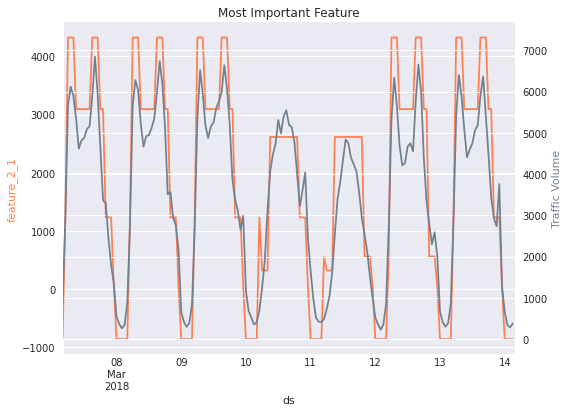

In [30]:
# plot the most important feature and actual data over the course of one week
fig, ax1 = plt.subplots()

features_forecast.to_pandas().set_index('ds')[most_important].plot(ax=ax1, color=col_getml_alt)
ax1.set_ylabel(most_important, color=col_getml_alt)

ax2 = ax1.twinx()  
ax2.set_ylabel('Traffic Volume', color=col_data)
traffic[idx_train].set_index('ds')['Traffic_Volume'].plot(ax=ax2, color=col_data)

fig.tight_layout()
plt.title('Most Important Feature')
plt.xlim(t_split - pd.Timedelta('7d'), t_split)
plt.show()

While the feature is less smooth, it is really close to what we got in the 1-step case. This is another indication for the prescence of strong time-related patterns in the data.

## Benchmarks against Prophet

By design, Prophet isn't capable of delivering the 1-step ahead predictions we did with getML. In order to retrieve a benchmark in the 1-step case nonetheless, we mimic 1-step ahead predictions through cross validating the model on a rolling origin. This clearly gives Prophet an advantage as all information up to the origin is incorporated when *fitting* the model and a new fit is calculated for every 1-step ahead forecast. Prophet's performance thus has to be viewed as an upper bound. Further, as noted above, we thought it would be interesting to let Multirel and Relboost figure out time based patterns by itself if we provide only deterministic components. So, in a second step, we benchmark this case against Prophet. For both tools, we use very simple models with all hyperparameters set to their default values.

Here we fit the model. We fit a new Prophet model for every hour. This is a computationally expensive operation even for our test subsample of 30 days. For the 720 hours (= 720 models) it takes around 6 hours. Therefore we read the predicitions from disc. If you want to reestimate the Prophet predicitions, you can rename the csv files on disc.

In [31]:
from scipy import stats

try:
    from fbprophet import Prophet
    from fbprophet.diagnostics import cross_validation

except ModuleNotFoundError:
    pass
    
    
try:
    prediction_prophet = pd.read_csv('pred_prophet_30d.csv')
    prediction_prophet['ds'] = pd.to_datetime(prediction_prophet['ds'])
    
except FileNotFoundError:
    # Rename columns to follow Prophet convention
    traffic_prophet = traffic[['ds', 'Traffic_Volume']].rename(
        {'Traffic_Volume': 'y'}, axis='columns'
    )
    
    # The actual prediction. One model for every 1h ahead prediction.

    train_window = traffic[idx_train]['ds'].max() - traffic[idx_train]['ds'].min()
    traffic_train = traffic_prophet[traffic_prophet['ds'] < t_split + pd.Timedelta('30d')]

    model_prophet = Prophet()
    model_prophet.fit(traffic_train)

    # Cross validate
    prediction_prophet = cross_validation(model_prophet,
                                          horizon='1h',
                                          period='1h',
                                          initial=train_window)
    # Save predictions
    prediction_prophet.to_csv('pred_prophet_30d.csv',
                              encoding='utf-8', index=False)

Score the model.

In [32]:
# Calculate score
r2_prophet = stats.pearsonr(prediction_prophet['yhat'].values,
                            prediction_prophet['y'].values)[0]**2
print('R2:', r2_prophet)

R2: 0.8330137758147999


getML is able to outperform Prophet's 1-step ahead predictions by about 14 percentage points in terms of predictive accuracy. This is a substantial margin. But we have to state that it may be an unfair comparison because we use Prophet for an application it wasn't designed for. To deal with this critique we also calculate h-step predictions below.

Next, we visually compare the 1-step ahead Prophet with 1-step ahead getML predictions. 

In [33]:
# Predict with getML
prediction_getml_ = pipe.predict(
    population_table=df_test,
    peripheral_tables=[df_full]
)

prediction_getml = pd.DataFrame(np.array(prediction_getml_), columns=['Traffic_Volume'])
prediction_getml['ds'] = traffic[~idx_train]['ds'].values


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%



Note that with getML we calculate predictions for the *full sample* (instead of just 30 days). This plays as another advantage for Prophet.

We inspect the predictions of both models over the course of a week. Here, we plot the getML and Prophet predictions against actual values (data).

(422620.0, 422788.0)

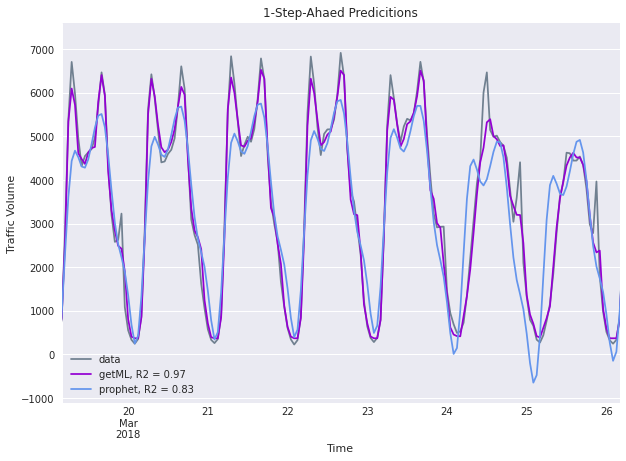

In [34]:
# Plot all together
traffic[~idx_train].set_index('ds')['Traffic_Volume'].plot(label='data', figsize=(10, 7), color=col_data)
prediction_getml.set_index('ds')['Traffic_Volume'].plot(label='getML, R2 = {:.2f}'.format(out_of_sample['rsquared'][0]), color=col_getml)
prediction_prophet.set_index('ds')['yhat'].plot(label='prophet, R2 = {:.2f}'.format(r2_prophet), color=col_prophet)
plt.title('1-Step-Ahaed Predicitions')
plt.legend()
plt.ylabel('Traffic Volume')
plt.xlabel('Time')
# We shift the data by 5 days to let the plot start on a mondey
plt.xlim(t_split+pd.Timedelta('5d'), t_split+pd.Timedelta('12d'))

What can we take from this plot? The strong time-related patterns carry on to the testing set and the xgboost is able to incorporate this information to deliver highly accurate 1-step ahead predictions. Notice that Prophets additive components model results in negative predictions for the weekends' lows at night. We can also see an anomaly on March, 24 that neither model is able to predict (feel free to play with the window to verify that its an annomaly).

Now we benchmark the performance of h-step ahead forecasts. Remember, in the models, only deterministic features are incorporated. Here, we fit the h-step ahead forecast with Prophet. This is how Prophet is meant to be applied. We allow for multiplicative seasonalities to at least partially remedy the problem with negative predictions discussed above.

In [35]:
# h-step ahead forecast with Prophet
try:
    forecast_prophet = pd.read_csv('forecast_prophet.csv')
    forecast_prophet['ds'] = pd.to_datetime(forecast_prophet['ds'])

except FileNotFoundError:    
    
    model_forecast_prophet = Prophet(seasonality_mode='multiplicative')
    model_forecast_prophet.fit(traffic_train_prophet)

    future = pd.DataFrame(traffic[~idx_train]['ds'])

    forecast_prophet = model_forecast_prophet.predict(future)

    forecast_prophet.to_csv('forecast_prophet.csv',
                            encoding='utf-8', index=False)

A typical Prophet components graph. 

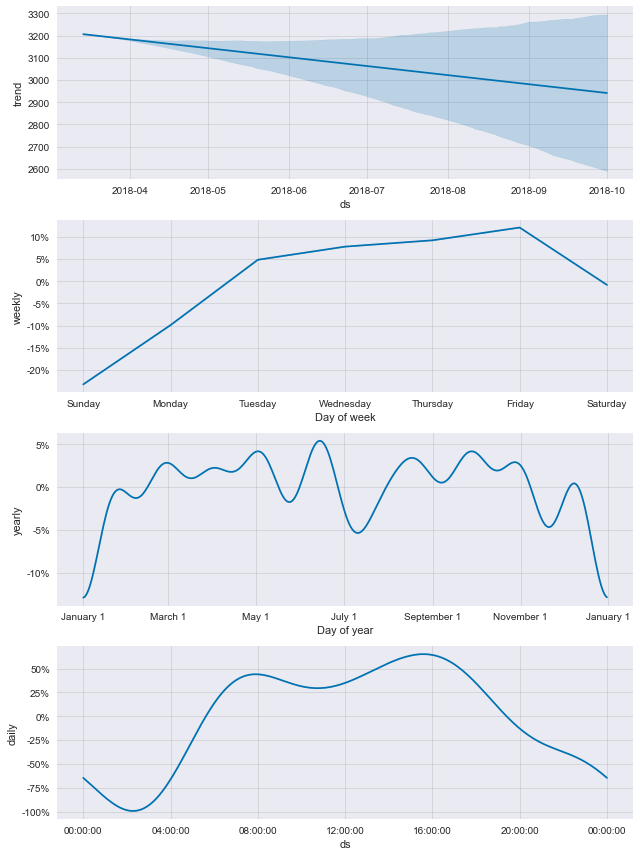

In [36]:
from IPython.display import Image

try:
    display(Image(filename='components.png'))
except FileNotFoundError:
    model_forecast_prophet.plot_components(forecast_prophet)
    pd.plotting.register_matplotlib_converters()

Seasonalities are now applied multiplicatively, but the combination of the totally bottoming out daily cycle and the negative additive trend will result in negative predictions nontheless.

Score the Prophet model.

In [37]:
r2_forecast_prophet = stats.pearsonr(forecast_prophet['yhat'].values,
                                     traffic[~idx_train]['Traffic_Volume'].values)[0]**2
print('R2:', r2_forecast_prophet)

R2: 0.8243740695841962


Remember, getML's predicition accuracy in the h-step case was arround 94 %. So getML is still ahead of Prophet by about 12 percentage points. That is, competing with Prophet in its core business.

Here is a visual comparison of the h-step ahead forecasts:

In [38]:
# h-step ahead forecast using the getML forecast specification from above
forecast_getml_ = pipe_forecast.predict(
    population_table=df_test,
    peripheral_tables=[df_full])

forecast_getml = pd.DataFrame(np.array(forecast_getml_), columns=['Traffic_Volume'])
forecast_getml['ds'] = traffic[~idx_train]['ds'].values


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%



We inspect the forecasts over the course of the same period as above.

(422620.0, 422788.0)

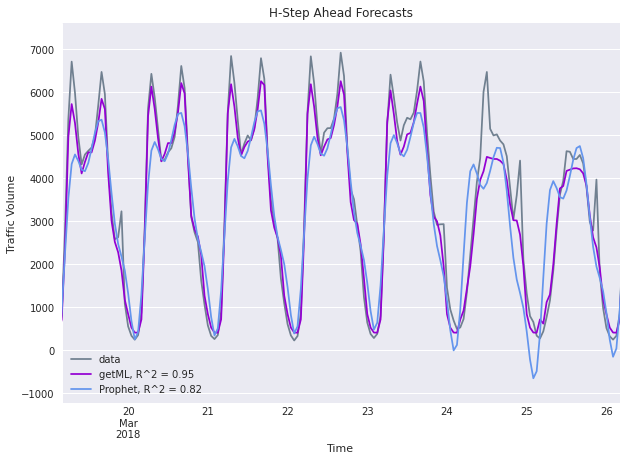

In [39]:
# plot
traffic[~idx_train].set_index('ds')['Traffic_Volume'].plot(label='data', figsize=(10, 7), color=col_data)
forecast_getml.set_index('ds')['Traffic_Volume'].plot(label='getML, R^2 = {:.2f}'.format(out_of_sample_forecast['rsquared'][0]), color=col_getml)
forecast_prophet.set_index('ds')['yhat'].plot(label='Prophet, R^2 = {:.2f}'.format(r2_forecast_prophet), color=col_prophet)
plt.legend()
plt.title('H-Step Ahead Forecasts')
plt.ylabel('Traffic Volume')
plt.xlabel('Time')
plt.xlim(t_split+pd.Timedelta('5d'), t_split+pd.Timedelta('12d'))

We lose some accuracy but the predictions are still very accurate. All important time-related patterns are still present. And the combination of the features results in a relatively smooth approximation of the data.

## Augmenting the model with holiday data

In a last step, we augment data on national holidays. 

First, we import the holiday data. Holidays are deterministic, therefore we can include them in the population table and allow the algorithm to use contemporary information about whether the current day is a holiday or not. If this information was not contemporarly available, we would introduce a data leak here.

In [40]:
# import holidays
holidays = pd.read_csv('https://raw.githubusercontent.com/dreyco676/Anomaly_Detection_A_to_Z/master/supplemental_data/usholidays.csv')
holidays['ds'] = pd.to_datetime(holidays['ds'])
holidays.sort_values(by=['ds'], inplace=True)
holidays.drop_duplicates('ds', inplace=True)
holidays.set_index('ds', inplace=True)

traffic['ds_day'] = traffic['ds'].dt.floor('d')
traffic = traffic.reset_index().merge(holidays, how='left', left_on='ds_day', right_on='ds').set_index('index')
traffic['holiday'] = traffic['holiday'].fillna('No holiday')

# update roles
roles = dict(
    time_stamp=['ds'],
    join_key=['join_key'],
    target=['Traffic_Volume'],
    categorical=['holiday', 'hour', 'weekday', 'day', 'month', 'year'])

Now, we update data on the engine using the new pandas dataframe that includes holiday data.

In [41]:
df_full = getml.data.DataFrame.from_pandas(
    traffic, name='full', roles=roles)

df_train = getml.data.DataFrame.from_pandas(
    traffic[idx_train], name='train', roles=roles)

df_test = getml.data.DataFrame.from_pandas(
    traffic[~idx_train], name='test', roles=roles)

Our data model still consists of two tables.

In [42]:
# Add placeholder to datamodel
population = getml.data.Placeholder('population')
peripheral = getml.data.Placeholder('peripheral')

population.join(
    peripheral,
    join_key='join_key',
    time_stamp='ds',
    horizon=getml.data.time.hours(1),
    memory=getml.data.time.days(7),
    allow_lagged_targets=True
)

population

placeholder,other placeholder,allow lagged targets,horizon,join keys used,memory,other join keys used,other time stamps used,time stamps used,upper time stamps used
population,peripheral,True,3600.0,join_key,604800.0,join_key,ds,ds,


In [43]:
pipe_full = getml.pipeline.Pipeline(
    tags=['memory: 7d', 'holidays', 'weather', 'multirel', 'relboost'],
    population=population,
    peripheral=[peripheral],
    feature_learners=[multirel, relboost],
    predictors=[predictor]
)

In [44]:
pipe_full.check(df_train, [df_full])

Checking data model...
OK.


In [45]:
pipe_full.fit(df_train, [df_full])

Checking data model...
OK.

MultirelModel: Training features...
[========================================] 100%

RelboostModel: Training features...
[========================================] 100%

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:5m:41.614272



Pipeline(feature_learners=['MultirelModel', 'RelboostModel'], 
         feature_selectors=[], include_categorical=False, 
         peripheral=['peripheral'], population='population', 
         predictors=['XGBoostRegressor'], 
         tags=['memory: 7d', 'holidays', 'weather', 'multirel', 'relboost'], 
         share_selected_features=0.5)

url: /user/getml-getml-demo-py50cete/proxy/1709/getpipeline/Gf8Fid/0/

In [46]:
# Score the model
in_sample_full = pipe_full.score(df_train, [df_full])
print('In sample:', in_sample_full)

out_of_sample_full = pipe_full.score(df_test, [df_full])
print('Out of sample:', out_of_sample_full)


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

In sample: {'mae': [220.8214734123564], 'rmse': [340.74404080220137], 'rsquared': [0.9700006078332194]}

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

Out of sample: {'mae': [201.47861529465038], 'rmse': [320.2377363156172], 'rsquared': [0.974113033036103]}


We see that our results don't get much better (compared to the 1-step ahead case above). Actually, the difference here is mere noise. But note that getML already delivered very accurate predictions before. And sometimes there is just no additional valuable information in the data. This is not that surprising for the holiday data, given that most information about holidays is fully reproducible from calendarial information we extracted earlier. In other words: for the algorithm, it doesn't matter if the traffic is lower on any 4th of July of a given year or if there is a corresponding holiday named 'Independence Day'.

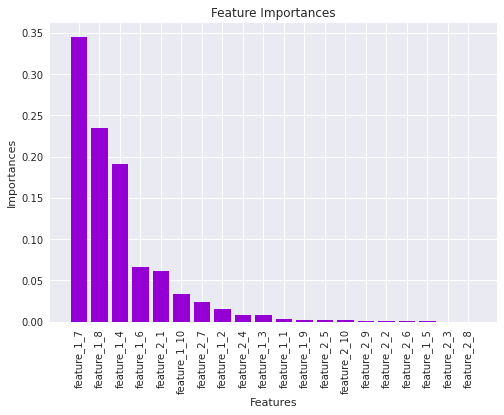

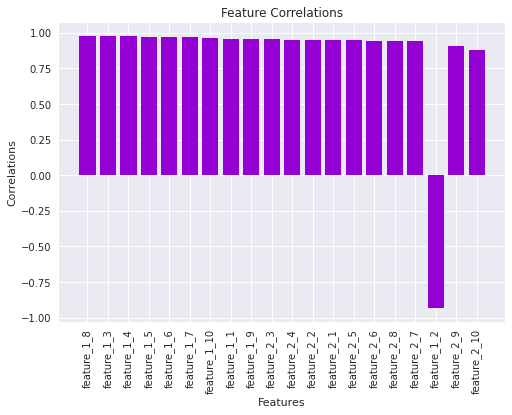

In [47]:
# Feature importances
names, importances = pipe_full.features.importances()
plt.bar(names, importances, color=col_getml)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

most_important = names[0]

# Feature correlations
names, correlations = pipe_full.features.correlations()
plt.bar(names, correlations, color=col_getml)
plt.title('Feature Correlations')
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

In [48]:
# Feature overview
pipe_full.features.to_pandas().head()

,names,correlations,importances,target,sql
0,feature_1_1,0.955846,0.002637,Traffic_Volume,"CREATE TABLE ""FEATURE_1_1"" AS\nSELECT MIN( t2...."
1,feature_1_2,-0.932993,0.015060,Traffic_Volume,"CREATE TABLE ""FEATURE_1_2"" AS\nSELECT SUM( ( j..."
2,feature_1_3,0.974205,0.007945,Traffic_Volume,"CREATE TABLE ""FEATURE_1_3"" AS\nSELECT SUM( t2...."
3,feature_1_4,0.974151,0.191708,Traffic_Volume,"CREATE TABLE ""FEATURE_1_4"" AS\nSELECT AVG( t2...."
4,feature_1_5,0.973618,0.000601,Traffic_Volume,"CREATE TABLE ""FEATURE_1_5"" AS\nSELECT SUM( t2...."


In [49]:
# SQL transpilation of most important feature
pipe_full.features.to_sql()[most_important]

```sql
CREATE TABLE "FEATURE_1_7" AS
SELECT SUM( t2."Traffic_Volume" ) AS "feature_1_7",
       t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "peripheral" t2
ON t1."join_key" = t2."join_key"
WHERE (
   ( ( datetime( t1."ds" ) > datetime( t2."ds", '+6.962922 days' ) ) AND ( t2."hour" NOT IN ( '0', '1', '2', '23' ) ) AND ( t1."holiday" IN ( 'Independence Day', 'Labor Day' ) ) AND ( t2."hour" NOT IN ( '5', '6' ) ) )
OR ( ( datetime( t1."ds" ) > datetime( t2."ds", '+6.962922 days' ) ) AND ( t2."hour" IN ( '0', '1', '2', '23' ) ) AND ( t2."day" NOT IN ( '4' ) ) AND ( t1."holiday" NOT IN ( 'Martin Luther King Jr Day', 'Columbus Day' ) ) )
OR ( ( datetime( t1."ds" ) <= datetime( t2."ds", '+6.962922 days' ) ) AND ( datetime( t1."ds" ) > datetime( t2."ds", '+1.295900 hours' ) ) AND ( datetime( t1."ds" ) > datetime( t2."ds", '+6.946057 days' ) ) AND ( t1."holiday" NOT IN ( 'Independence Day', 'Labor Day' ) ) )
OR ( ( datetime( t1."ds" ) <= datetime( t2."ds", '+6.962922 days' ) ) AND ( datetime( t1."ds" ) <= datetime( t2."ds", '+1.295900 hours' ) ) AND ( t2."hour" NOT IN ( '0', '1', '2', '3', '22', '23' ) ) AND ( t2."holiday" NOT IN ( 'Memorial Day', 'Thanksgiving Day', 'Christmas Day', 'Labor Day' ) ) )
) AND datetime( t2."ds", '+1.000000 hours' ) <= datetime( t1."ds" )
AND ( datetime( t2."ds", '+7.041667 days' ) > datetime( t1."ds" ) OR datetime( t2."ds", '+7.041667 days' ) IS NULL )
GROUP BY t1.rowid;
```

The feature above is a nice example where Multirel correctly attributed lower levels of traffic to the presence of holidays like Independence Day, Thanksgiving or Christmas. Such include/exclude conditions based on categorical columns are really nice, as they demonstrate getML's powerful out-of-the-box handling of categorical variables.

## Conclusion
Applying getML to hourly traffic data from a metropolitan section of the interstate 94 we were able to show the power and relevance of the Multirel algorithm on a real-world data set with complex characteristics. We benchmarked our results against Prophet because we expect Prophet to perform well on the given data set. getML outperformed Prophet predictions by up to 14 percantage points. A typical application for the modelling strategy from above could be the real-time prediction of traffic volume (and traffic jams) on a navigation device. Using the trained features to generate new predictions should not take longer than a few milliseconds, even on a low-powered device.